In [76]:
#
# Модель для распознания кошек и собак. 
# 85% точности на валидационной выборке
# Засабмитить не получилось, соревнование на kaggle закрыто
# Лучший скор 99% примерно с ттакой же сеткой
# link: https://www.kaggle.com/c/dogs-vs-cats/overview 

In [16]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [17]:
from os import listdir
from os.path import isfile, join
import copy
import matplotlib.pyplot as plt

import pandas as pd

import tensorflow as tf
from tensorflow.keras import Model
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

from helpers.image_helpers import display_images

In [65]:
PREFIX = "cat_dog_recognition/"
TRAIN_DIR = PREFIX + "train/" 
TEST_DIR = PREFIX + "test1/"

DF_RATE = 1.

In [66]:
def read_data(_dir):
    img_cnt = len(listdir(_dir))
    filenames = []
    y = []
    for image in listdir(_dir):
        filenames.append(image)
        y.append('Dog' if image.startswith('dog') else 'Cat')
        
    return pd.DataFrame({'filename': filenames, 'y': y})

In [20]:
df = read_data(TRAIN_DIRIN_DIR)
df_train, df_test = train_test_split(df, train_size=0.9, test_size=0.1)

#### Show random image

Cat


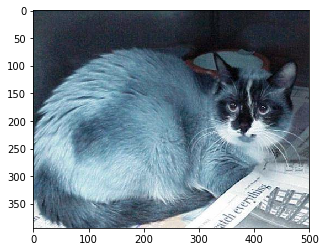

In [21]:
sample = df.sample()
print(sample['y'].values[0])
plt.imshow(cv2.imread(
    join(TRAIN_DIR, sample['filename'].values[0])
))
plt.show()


In [22]:
print("Cat cnt: {}, Dog cnt: {}".format(np.sum(df['y'] == 'Cat'), np.sum(df['y'] == 'Dog')) )

Cat cnt: 12500, Dog cnt: 12500


#### Model

In [23]:
class CatDogRecognitionModel(Model):
    def __init__(self):
        super(CatDogRecognitionModel, self).__init__()
        self.FilterSize1 = 32
        self.FilterSize2 = 64
        self.FilterSize3 = 128
        
        self.model_layers = [
            tf.keras.layers.Conv2D(filters=self.FilterSize1, kernel_size=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Conv2D(filters=self.FilterSize2, kernel_size=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),
            
            tf.keras.layers.Conv2D(filters=self.FilterSize3, kernel_size=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Dense(2, activation='softmax'),
        ]
        
    def call(self, x, *args, **kwargs):
        for model_layer in self.model_layers:
            x = model_layer(x, *args, **kwargs)
        return x

model = CatDogRecognitionModel()

#### Train Input Generator

In [24]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
        df_train.sample(n=int(len(df_train) * DF_RATE)),
        directory=TRAIN_DIR,
        x_col='filename', 
        y_col='y',
        target_size=(128, 128),
        batch_size=16,
        class_mode='binary')

Found 22500 validated image filenames belonging to 2 classes.


#### Test input generator

In [25]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
        df_test.sample(n=int(len(df_test) * DF_RATE)),
        directory=TRAIN_DIR,
        x_col='filename', 
        y_col='y',
        target_size=(128, 128),
        batch_size=16,
        class_mode='binary')

Found 2500 validated image filenames belonging to 2 classes.


#### Input generator checking

Found 1 validated image filenames belonging to 1 classes.


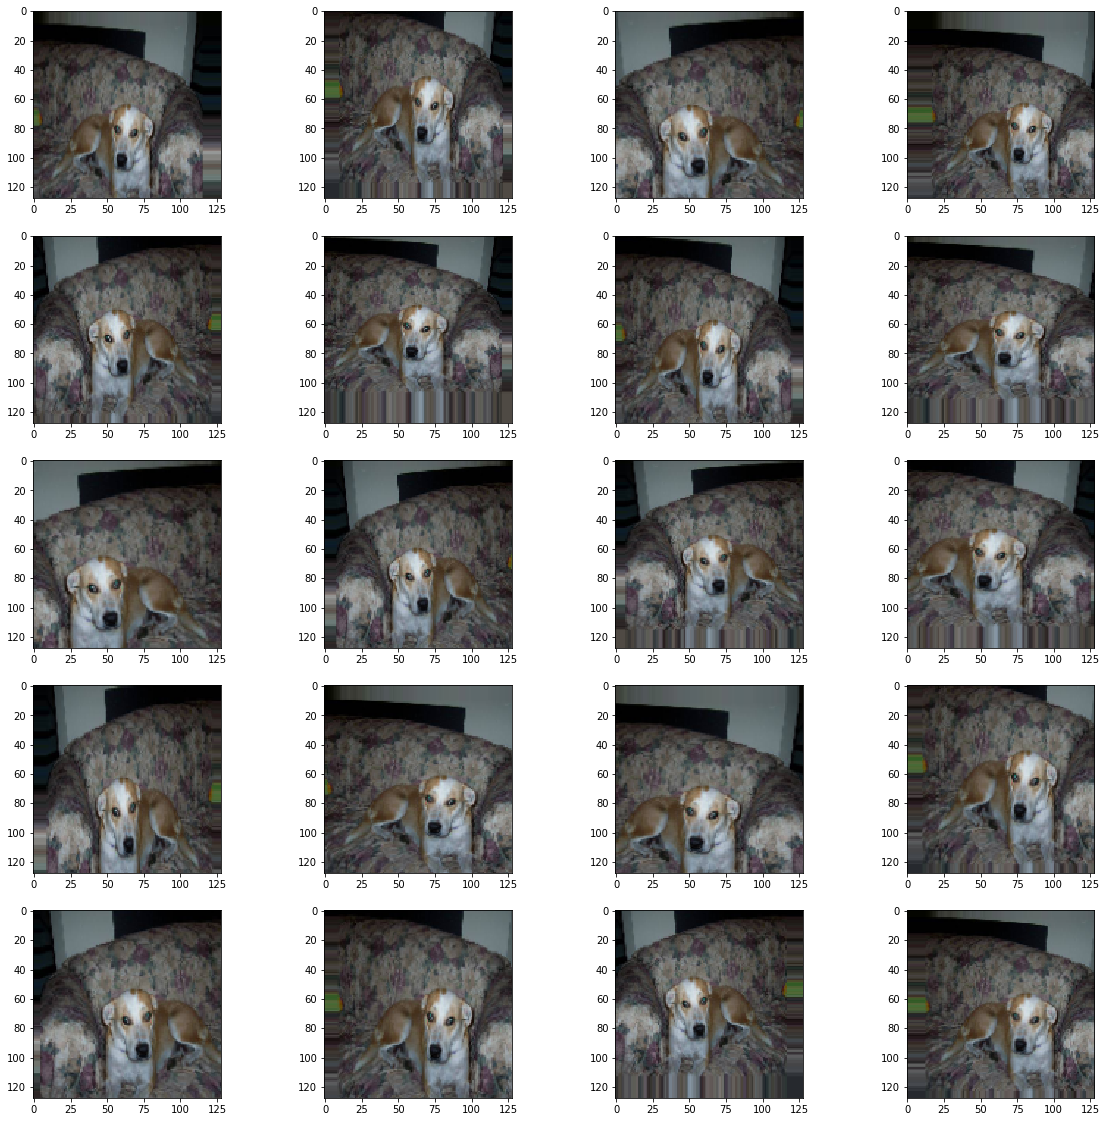

In [26]:
train_generator_example = train_datagen.flow_from_dataframe(
        df_train.iloc[0:1],
        directory=TRAIN_DIR,
        x_col='filename', 
        y_col='y',
        target_size=(128, 128),
        batch_size=64)

images = []
for i in range(20):
    img, labels = train_generator_example.next()
    #for j in range(img.shape[0]):
    images.append(img[0])
    

display_images(images, 4)

#### Callbacks

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10)

callbacks = [earlystop, learning_rate_reduction]

In [29]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

history = model.fit(
    x=train_generator,
    epochs=60,
    validation_data=test_generator,
    callbacks=callbacks
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 1407 steps, validate for 157 steps
Epoch 1/60
1407/1407 [==============================] - 1879s 1s/step - loss: 0.7553 - accuracy: 0.5951 - val_loss: 0.7543 - val_accuracy: 0.6136
Epoch 2/60
1407/1407 [==============================] - 2098s 1s/step - loss: 0.6408 - accuracy: 0.6505 - val_loss: 0.6941 - val_accuracy: 0.6728
Epoch 3/60
1407/1407 [==============================] - 3794s 3s/step - loss: 0.6170 - accuracy: 0.6724 - val_loss: 1.3731 - val_accuracy: 0.5924
Epoch 4/60
1407/1407 [==============================] - 2457s 2s/step - loss: 0.5864 - accuracy: 0.6983 - val_loss: 0.5992 - val_accuracy: 0.7260
Epoch 5/60
1407/1407 [==============================] - 1857s 1s/step - loss: 0.5677 - accuracy: 0.7134 - val_loss: 0.4555 - val_accuracy: 0.7924
Epoch 6/60
1407/1407 [==============================] - 1866s 1s/step - loss: 0.5433 - accuracy: 0.7297 - val_loss: 0.4827 - val_accuracy: 0.7756
Epoch 7/60
1406/1407 [============================>.] - ETA: 1s - loss: 0.5314 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
model.save_weights(PREFIX + "/model_85.h5")

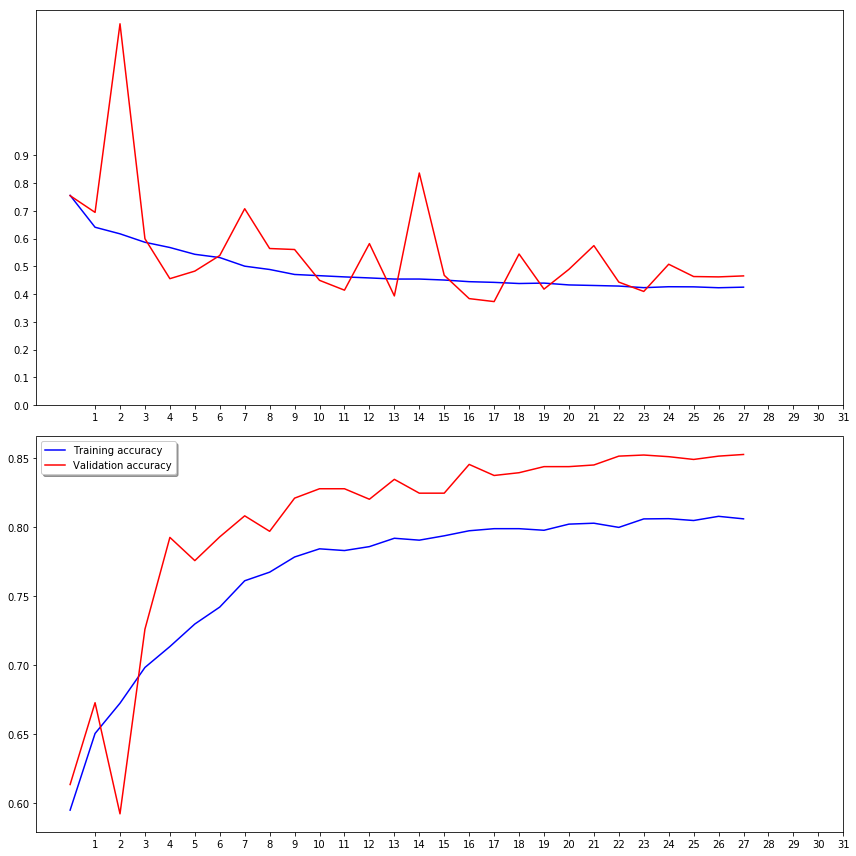

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 32, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 32, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [55]:
test_data = read_data(TEST_DIR)
test_data = test_data[['filename']]

In [56]:
print(test_data)

        filename
0       4626.jpg
1       9717.jpg
2       4150.jpg
3       7008.jpg
4       8941.jpg
...          ...
12495    780.jpg
12496  11975.jpg
12497   4053.jpg
12498   3670.jpg
12499  11503.jpg

[12500 rows x 1 columns]


#### Test Data Generator

In [73]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    test_data, 
    directory=TEST_DIR,
    x_col='filename', 
    y_col=None,
    class_mode=None,
    target_size=(128, 128),
    batch_size=15,
    shuffle=False
)

Found 12500 validated image filenames.


In [74]:
res = model.predict(test_generator)

In [75]:
print(res)

[[2.5563544e-04 9.9974436e-01]
 [9.9998927e-01 1.0745822e-05]
 [7.0288807e-01 2.9711190e-01]
 ...
 [1.2633821e-02 9.8736620e-01]
 [8.9412266e-01 1.0587727e-01]
 [3.2527846e-01 6.7472154e-01]]
